In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
customers = pd.read_csv('../data/customers_initial.csv')
transactions = pd.read_csv('../data/transactions_initial.csv')

## CLV analysis

In [14]:
from lifetimes.utils import summary_data_from_transaction_data

In [15]:
summary = summary_data_from_transaction_data(trans_free, 
                                             'customerId', 'Date', 'Total', observation_period_end='2017-09-16')


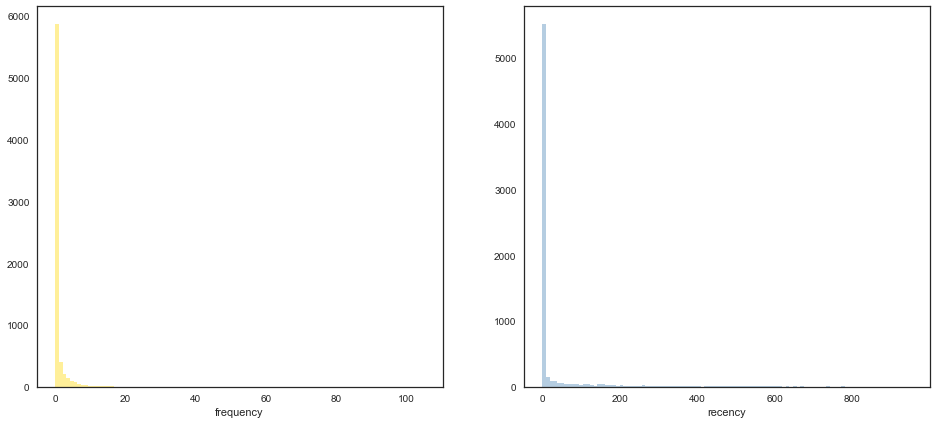

In [16]:
import seaborn as sns
sns.set_style("white")

fig, axarr = plt.subplots(1, 2, figsize=(16,7))

axarr[0] = sns.distplot(summary.frequency, kde=False, color='gold', ax=axarr[0], bins=100)
axarr[1] = sns.distplot(summary.recency, kde=False, color='steelblue', ax=axarr[1], bins=100)

# indicating vast majority of customers purchase a handful of times.

In [17]:
print "MAX \n"

for c in summary.columns:
    print  c, summary[c].max()

MAX 

frequency 105.0
recency 951.0
T 1123.0
monetary_value 1599.0


In [18]:
from lifetimes import BetaGeoFitter

# similar API to scikit-learn and lifelines.
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])
print bgf

<lifetimes.BetaGeoFitter: fitted with 7005 subjects, a: 0.90, alpha: 3.95, b: 1.58, r: 0.08>


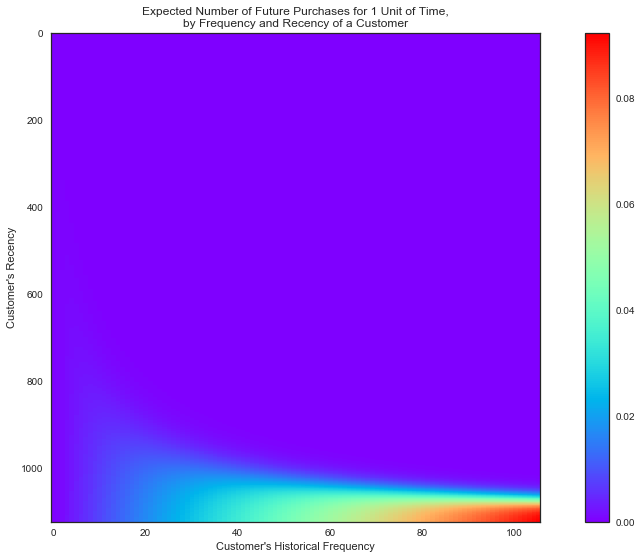

In [19]:
from lifetimes.plotting import plot_frequency_recency_matrix

fig, ax = plt.subplots(figsize=(16,9))
plot_frequency_recency_matrix(bgf, cmap = 'rainbow')

# daily transactions mean this is rather low, though large numbers of customers sign up, order 1 or 2 in short
# space of time (i.e. couple of days)

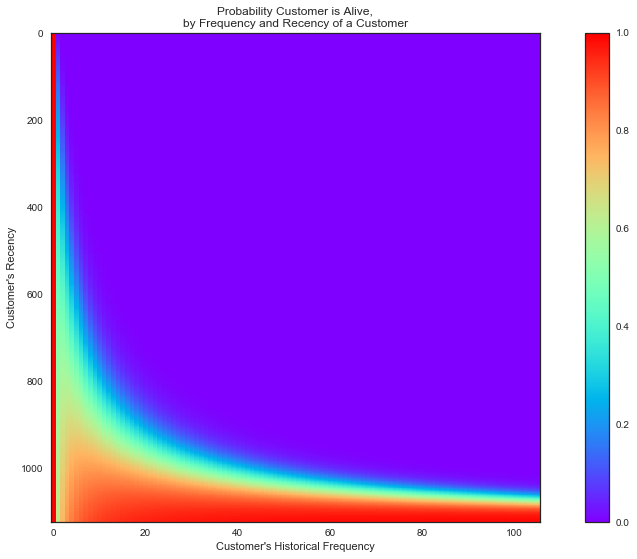

In [20]:
from lifetimes.plotting import plot_probability_alive_matrix

fig, ax = plt.subplots(figsize=(16,9))
plot_probability_alive_matrix(bgf, cmap = 'rainbow')

In [21]:
t = 90 # looking at the next 90 days

summary['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, 
                                                        summary['frequency'], summary['recency'], summary['T'],)
summary.sort_values(by='predicted_purchases', ascending = False).head(10)

,frequency,recency,T,monetary_value,predicted_purchases
customerId,,,,,
23508,33.0,104.0,106.0,1.242424,19.619842
30611,10.0,24.0,24.0,6.795000,15.186373
1919,105.0,842.0,844.0,29.864286,10.545892
566,80.0,832.0,835.0,25.300013,8.089227
8897,32.0,316.0,320.0,22.118125,7.681985
24836,12.0,95.0,96.0,1.395833,7.598792
11967,24.0,243.0,247.0,8.000000,7.162232
4031,46.0,420.0,445.0,26.281522,6.705090
27005,7.0,48.0,51.0,49.342857,6.469588


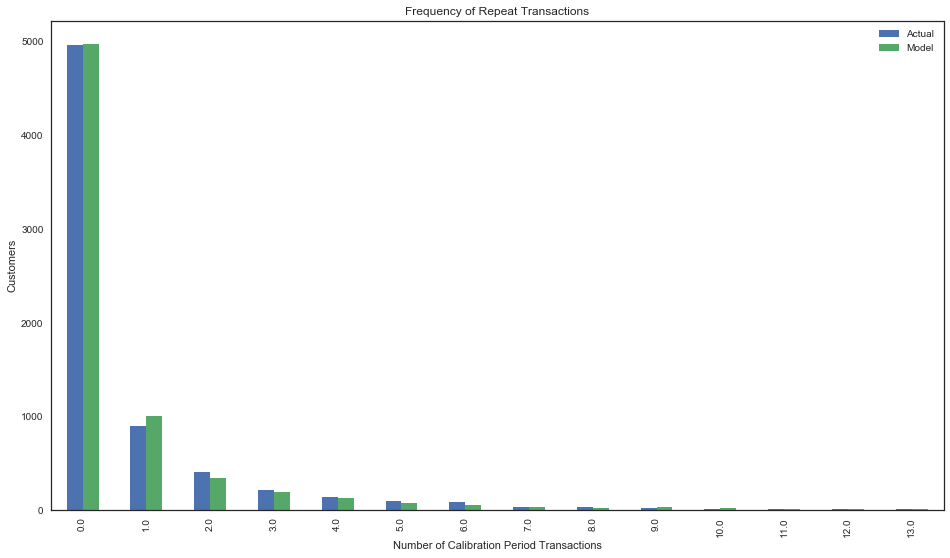

In [22]:
from lifetimes.plotting import plot_period_transactions

plot_period_transactions(bgf, max_frequency=14, figsize = (16,9))


In [23]:
from lifetimes.utils import calibration_and_holdout_data


summary_cal_holdout = calibration_and_holdout_data(transactions, 'customerId', 'Date',
                                        calibration_period_end='2017-06-30',
                                        observation_period_end='2017-09-16' )   
summary_cal_holdout.head()


,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
customerId,,,,,
2,0.0,0.0,752.0,0.0,78
7,1.0,1.0,705.0,0.0,78
8,2.0,520.0,724.0,0.0,78
9,13.0,294.0,452.0,0.0,78
16,0.0,0.0,16.0,0.0,78


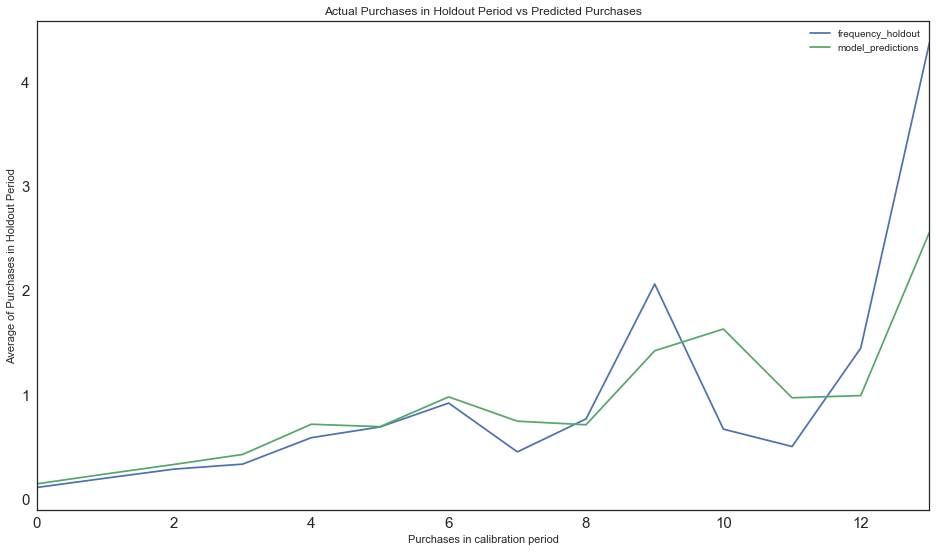

In [24]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases


bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout, n=14, figsize=(16,9), fontsize=15)

# model does fairly well until after 7th purchase
# influx of new customers recently which past hold out period not account for as well.

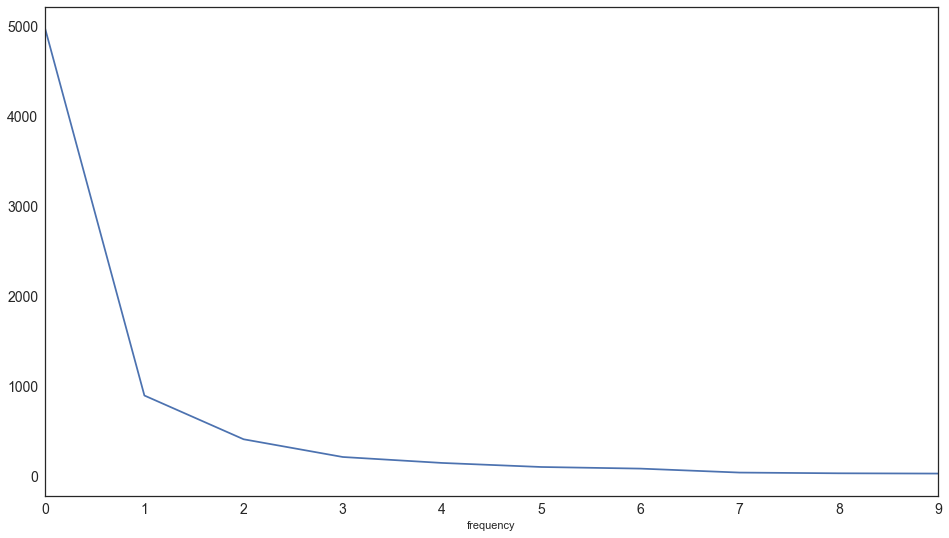

In [25]:
summary.groupby('frequency').size().head(10).plot(figsize=(16,9), fontsize=14)

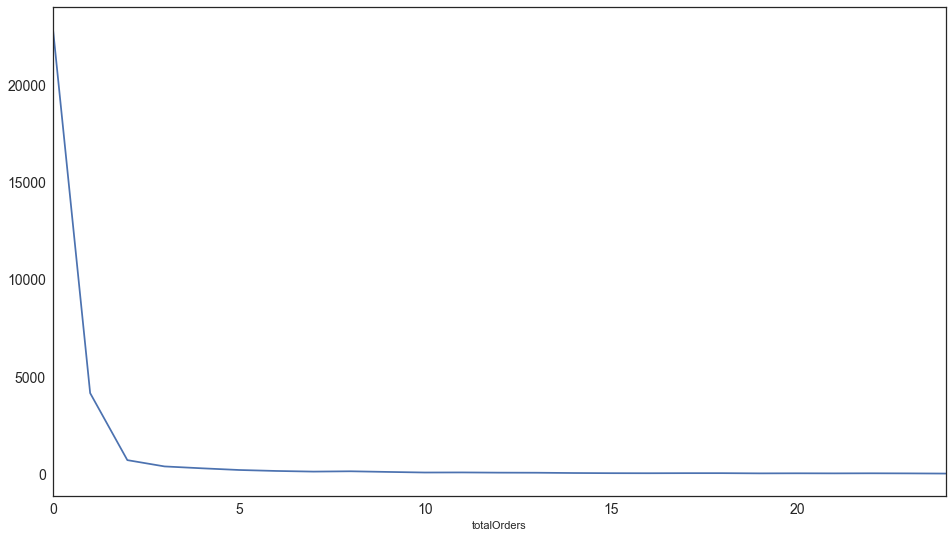

In [26]:
customers.groupby('totalOrders').size().head(25).plot(figsize=(16,9), fontsize=14)

## GammaGammaFitter - expected average lifetime value

In [27]:

returning_customers_summary = summary[summary['frequency']>0]
returning_customers_summary.head()

,frequency,recency,T,monetary_value,predicted_purchases
customerId,,,,,
7,1.0,1.0,783.0,6.000000,0.000870
8,3.0,567.0,849.0,18.000000,0.168678
9,13.0,294.0,530.0,3.461538,0.015033
26,1.0,744.0,854.0,79.000000,0.066682
27,2.0,409.0,750.0,41.000000,0.108193


In [28]:
returning_customers_summary[['monetary_value', 'frequency']].corr()

# The Gamma-Gamma submodel, assumes that there is no relationship between the monetary value 
# and the purchase frequency.

,monetary_value,frequency
monetary_value,1.00000,-0.04972
frequency,-0.04972,1.00000


At this point we can train our Gamma-Gamma submodel and predict the conditional, expected average lifetime value of our customers.

In [29]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print ggf


<lifetimes.GammaGammaFitter: fitted with 2037 subjects, p: 0.54, q: 1.48, v: 100.45>


In [30]:
# refitting with monetary value

ggf_clv = ggf.customer_lifetime_value(
            bgf, #the model to use to predict the number of future transactions
            summary['frequency'],
            summary['recency'],
            summary['T'],
            summary['monetary_value'],
            time=12, # months
)

print ggf_clv.sum()
ggf_clv.head()

393426.347795


customerId
2    9.668115
3    9.476054
4    9.465608
6    9.465608
7    0.582528
Name: clv, dtype: float64

In [31]:
# expected revenue from customer base over next 12 months

ggf_clv.sum()

393426.3477950404

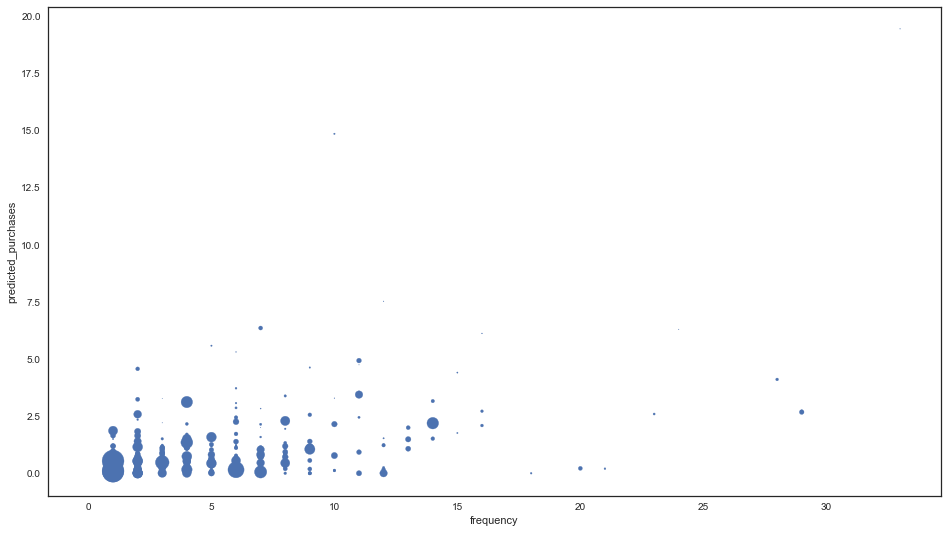

In [91]:
summary.plot.scatter('frequency', 'predicted_purchases', figsize=(16,9), s = summary.monetary_value/3)

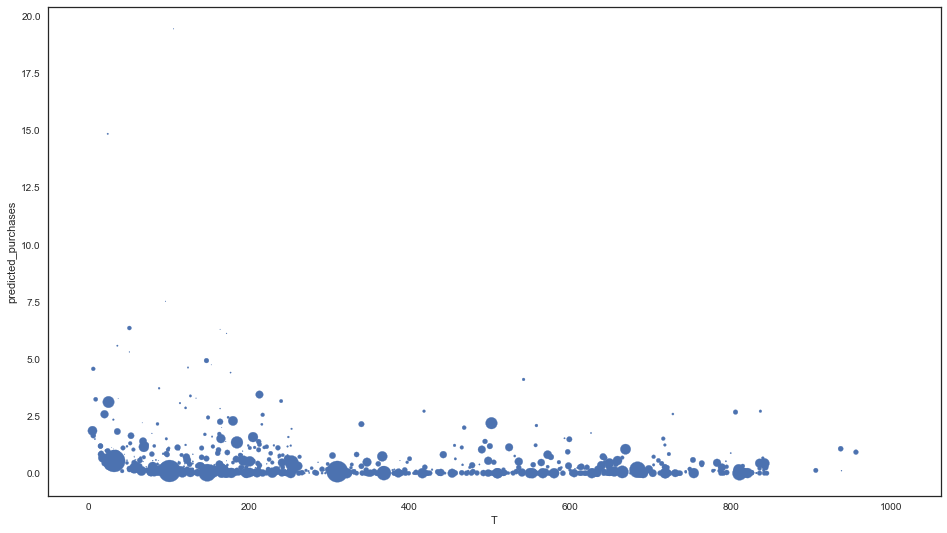

In [92]:
summary.plot.scatter('T', 'predicted_purchases', figsize=(16,9), s = summary.monetary_value/3)

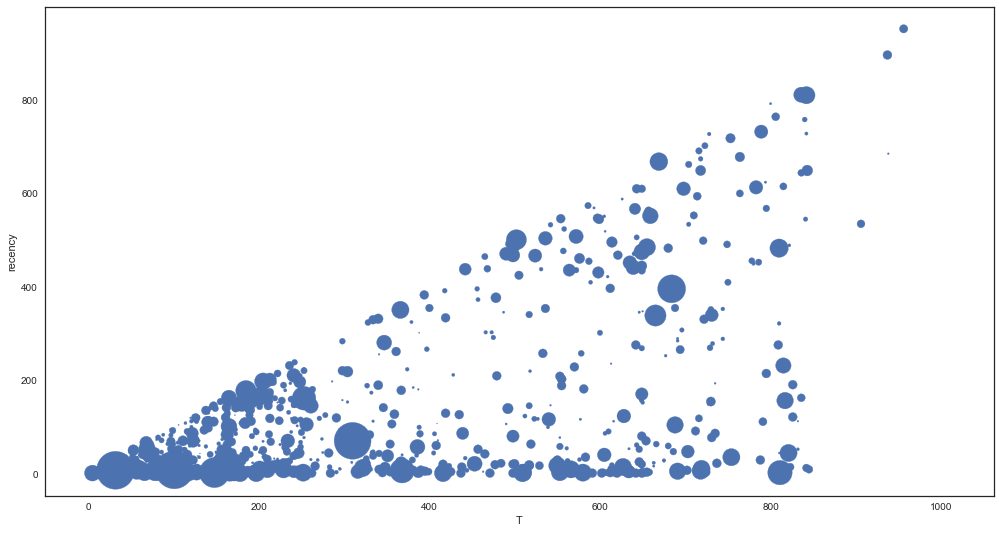

In [90]:
summary.plot.scatter('T', 'recency',figsize=(17,9), s=summary.monetary_value)

#### making a csv for ggf_clv for prediction, 
yes this is inefficient

In [33]:
ggf_df = ggf_clv.to_frame(name='clv')
#ggf_df.reset_index(inplace=True)
ggf_df['summary_mon'] = summary.loc[:,['monetary_value']]
print ggf_df.shape

(7005, 2)


In [34]:
ggf_df.head()

,clv,summary_mon
customerId,,
2,9.668115,0.0
3,9.476054,0.0
4,9.465608,0.0
6,9.465608,0.0
7,0.582528,6.0


#### export to csv for model

In [35]:
ggf_df.to_csv('../data/customer_value.csv', encoding='utf8')

In [36]:
cust_trans = transactions.groupby(['customerId']).Total.sum().to_frame(name='Total')

print cust_trans.shape
cust_trans.head()

cust_trans.to_csv('../data/customer_total.csv', encoding='utf8')


(2878, 1)


## Churn estimation

In [37]:
trans_free['customerId'].nunique()

7005

In [38]:
def get_diff(x):
    series_1 = x['Date'].sort_values().diff()
    return series_1

df_cust_group = trans_free.groupby('customerId').apply(lambda x: get_diff(x)).reset_index().drop('level_1',axis=1)

In [39]:
df_cust_group['days'] = df_cust_group['Date'].dt.days

In [40]:
mean_return_time = df_cust_group.groupby('customerId')['days'].mean().dropna()

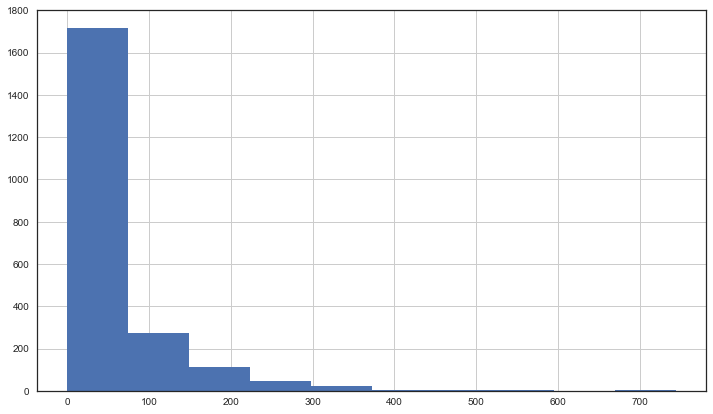

In [41]:
mean_return_time.hist(figsize=(12,7))

# most customers who return do so within 150 days of first transactions.

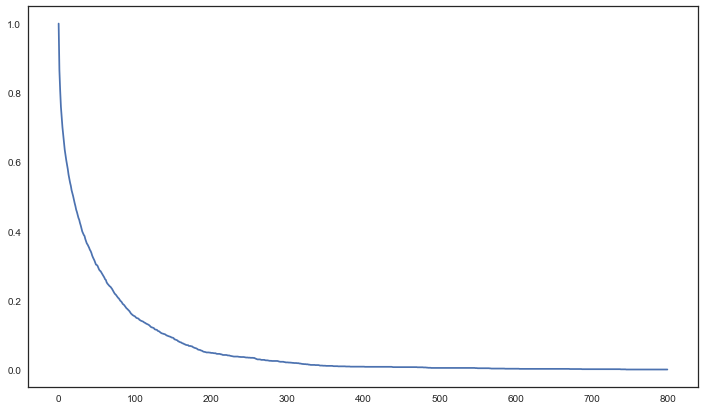

In [42]:
prob = [np.sum(mean_return_time>=i)*1.0/len(mean_return_time) for i in range(800)]
plt.figure(figsize=(12,7))
plt.plot(prob)

Based on this, could assume a customer has churned at 300 days of now activity

## CLV - shopify customers
There is a world of further analysis that I could do with CLV and predictions I feel.

I'm calling it OOS for this capstone though.

In [43]:
dns = pd.read_csv('../datasets/dns_clean.csv')

In [44]:
trans_shopify = pd.merge(trans_free, dns[['customerId','shopify']][dns.shopify == True], 
                         left_on='customerId', right_on='customerId')

In [61]:
ssummary = summary_data_from_transaction_data(trans_shopify, 
                                             'customerId', 'Date', 'Total', observation_period_end='2017-09-16')


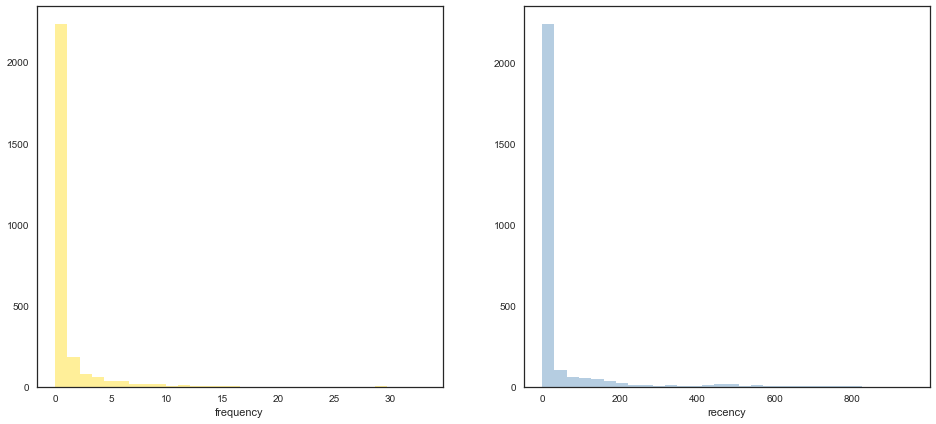

In [62]:
import seaborn as sns
sns.set_style("white")

fig, axarr = plt.subplots(1, 2, figsize=(16,7))

axarr[0] = sns.distplot(ssummary.frequency, kde=False, color='gold', ax=axarr[0], bins=30)
axarr[1] = sns.distplot(ssummary.recency, kde=False, color='steelblue', ax=axarr[1], bins=30)

In [63]:
from lifetimes import BetaGeoFitter

# similar API to scikit-learn and lifelines.
sbgf = BetaGeoFitter(penalizer_coef=0.0)
sbgf.fit(ssummary['frequency'], ssummary['recency'], ssummary['T'])
print sbgf

<lifetimes.BetaGeoFitter: fitted with 2709 subjects, a: 0.93, alpha: 3.90, b: 1.50, r: 0.11>


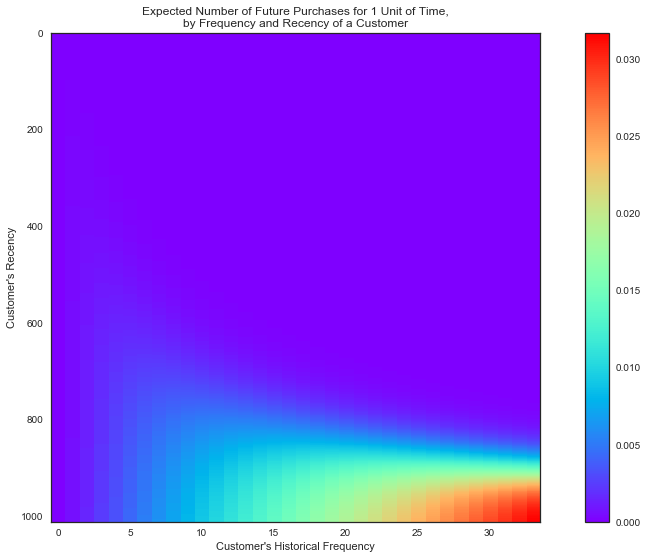

In [66]:
from lifetimes.plotting import plot_frequency_recency_matrix

fig, ax = plt.subplots(figsize=(16,9))
plot_frequency_recency_matrix(sbgf, cmap = 'rainbow')

# Recency less flat than overall.


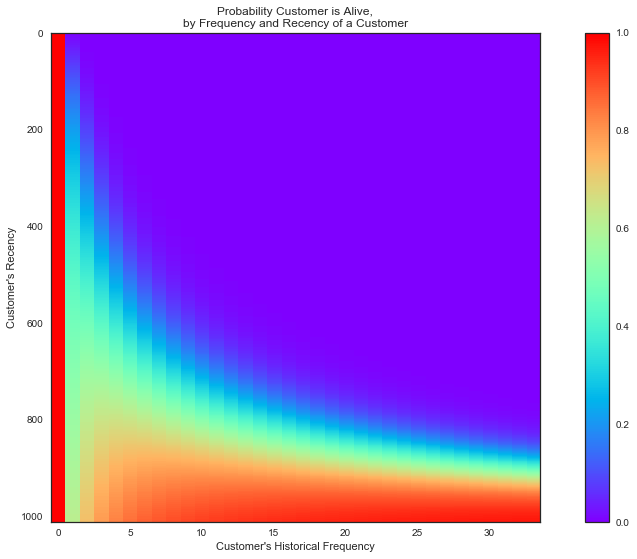

In [64]:
from lifetimes.plotting import plot_probability_alive_matrix

fig, ax = plt.subplots(figsize=(16,9))
plot_probability_alive_matrix(sbgf, cmap = 'rainbow')

# less red to the extreme left hand size, wider spread of probabilities.

In [67]:
t = 90 # looking at the next 90 days

ssummary['predicted_purchases'] = sbgf.conditional_expected_number_of_purchases_up_to_time(t, 
                                                        ssummary['frequency'], ssummary['recency'], ssummary['T'],)
ssummary.sort_values(by='predicted_purchases', ascending = False).head(10)

# shopify customers looking more active.

,frequency,recency,T,monetary_value,predicted_purchases
customerId,,,,,
23508,33.0,104.0,106.0,1.242424,19.427197
30611,10.0,24.0,24.0,6.795000,14.837101
24836,12.0,95.0,96.0,1.395833,7.516566
27005,7.0,48.0,51.0,49.342857,6.348243
19434,24.0,145.0,164.0,0.939208,6.290770
18794,16.0,164.0,172.0,2.328125,6.111780
29678,5.0,34.0,36.0,6.402000,5.575120
25003,6.0,47.0,51.0,2.141667,5.302542
21192,11.0,145.0,147.0,67.927273,4.924858


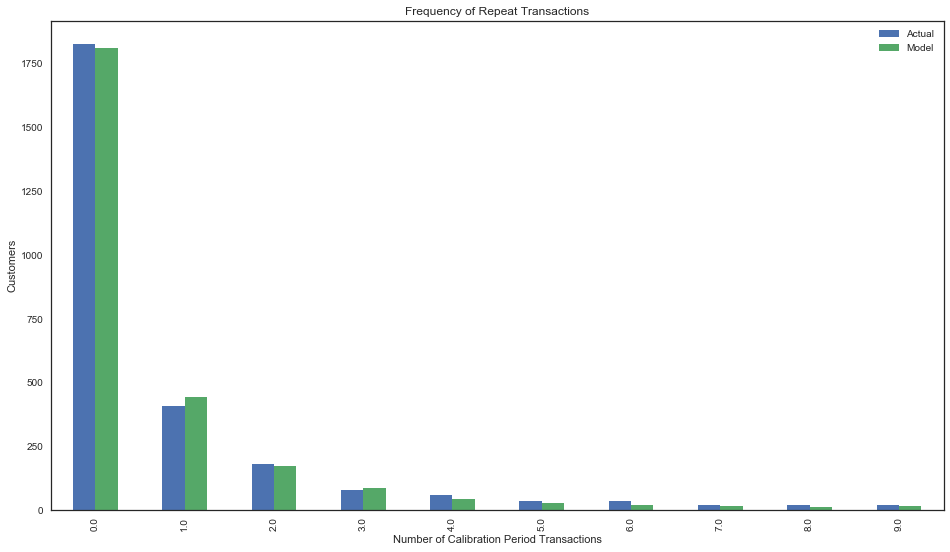

In [68]:
from lifetimes.plotting import plot_period_transactions

plot_period_transactions(sbgf, max_frequency=10, figsize = (16,9))

# Model working well, though most customers are making 0 purchases in a 10 day period.

In [70]:
from lifetimes.utils import calibration_and_holdout_data


ssummary_cal_holdout = calibration_and_holdout_data(trans_shopify, 'customerId', 'Date',
                                        calibration_period_end='2017-06-30',
                                        observation_period_end='2017-09-16', )   
ssummary_cal_holdout.head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
customerId,,,,,
4,0.0,0.0,771.0,0.0,78
16,0.0,0.0,16.0,0.0,78
21,0.0,0.0,755.0,0.0,78
27,2.0,409.0,672.0,0.0,78
96,5.0,614.0,737.0,0.0,78


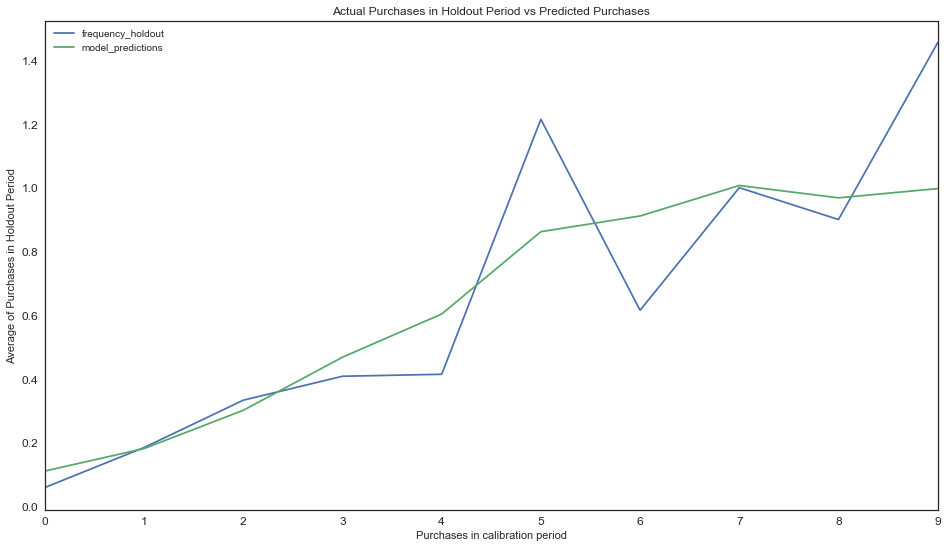

In [71]:
## from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases


sbgf.fit(ssummary_cal_holdout['frequency_cal'], ssummary_cal_holdout['recency_cal'], ssummary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(sbgf, ssummary_cal_holdout, n=10, figsize=(16,9), fontsize=12)

# model does fairly well until after 7th purchase
# influx of new customers recently which past hold out period not account for as well.

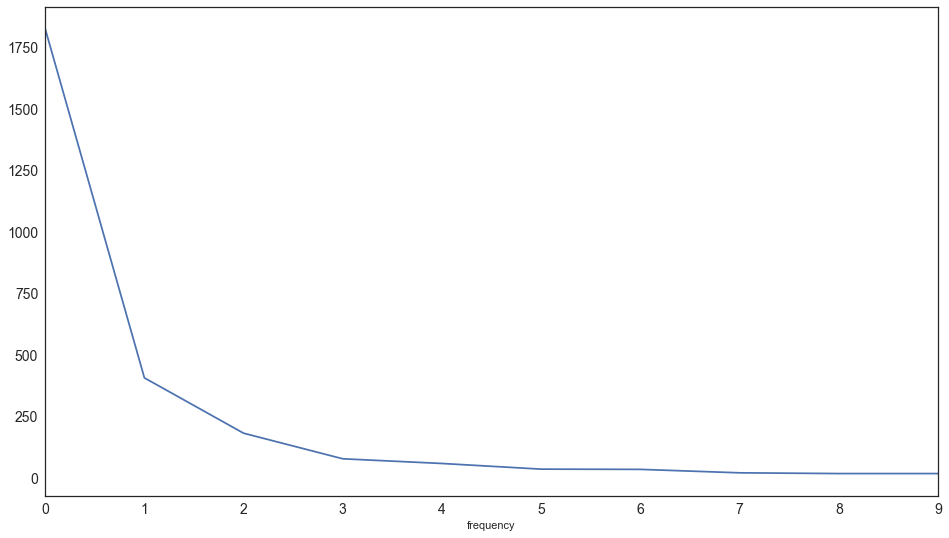

In [72]:
ssummary.groupby('frequency').size().head(10).plot(figsize=(16,9), fontsize=14)

# similar frequency curve as previous

In [ ]:
### Notes to self.

In [ ]:
# http://kpei.me/blog/?p=921





In [83]:
ggf = GammaGammaFitter(penalizer_coef = 0)
ret_cust_data = summary[summary['frequency'] > 0] # only look at customers with repeat purchases
# ret_cust_data['monetary_value'] = ret_cust_data['monetary_value']
ggf.fit(ret_cust_data['frequency'], ret_cust_data['monetary_value'])
p,q,v = ggf._unload_params('p', 'q', 'v')
print ggf


<lifetimes.GammaGammaFitter: fitted with 884 subjects, p: 0.45, q: 1.45, v: 60.17>


In [84]:
avg_cond_profit = ggf.conditional_expected_average_profit(summary['frequency'], summary['monetary_value'])
print "Expected conditional Average profit: %s, Population Average profit %s, Average profit: %s" % (
    avg_cond_profit, 
    (p*v)/(q-1),
    ret_cust_data['monetary_value'].mean()
)

Expected conditional Average profit: customerId
4         58.925657
16        58.925657
21        58.925657
27        47.058642
96        52.842325
128       58.925657
154       58.925657
165       58.925657
170       58.925657
175       58.925657
179       58.925657
207       29.770758
213       58.925657
215       12.484346
218       61.398377
234       68.858094
241       58.925657
247       58.925657
250       58.925657
256       58.925657
260       58.925657
270       58.925657
279       58.925657
295       58.925657
314       68.858094
378       77.538081
389       58.925657
390       58.925657
417       21.902153
419       58.925657
            ...    
31758     32.738959
31776     58.925657
31781     58.925657
31797     68.858094
31838     58.925657
31869     58.925657
31872     49.958258
31874     58.925657
31879     58.925657
31891     58.925657
31901     58.925657
31904     58.925657
31916    155.519279
31935     58.925657
31940     58.925657
31961     58.925657
31968     58

In [93]:
len(avg_cond_profit)

2709

In [99]:
trans_free.groupby('customerId').PromoCodeID

In [101]:
dns

,Unnamed: 0,bigcommerce,dns_lookup,expired_domain,shopify,valid_domain,website,wix,customerId
0,0,False,www.sovereignglobaladvisors.com is an alias fo...,False,False,True,www.sovereignglobaladvisors.com,True,1
1,1,False,sansche-yoga.com has address 192.0.78.24\nsans...,False,False,True,http://sansche-yoga.com/,False,2
2,2,False,amazon.co.uk has address 178.236.6.251\namazon...,False,False,True,amazon.co.uk,False,3
3,3,False,www.zopella.com is an alias for edgetrade.mysh...,False,True,True,www.zopella.com,False,4
4,4,False,zachhiltyphoto.com has address 198.49.23.145\n,False,False,True,zachhiltyphoto.com,False,5
5,5,False,no such domain,True,False,True,www.jainson.net,False,6
6,6,True,www.illumenature.com is an alias for illumenat...,False,False,True,http://www.illumenature.com,False,7
7,7,False,paperboyshop.com has address 98.124.199.46\npa...,False,False,True,paperboyshop.com,False,8
8,8,False,no such domain,True,False,True,Www.lachish-homemade-body-scrubs@myshopify.com,False,9
9,9,False,glitzplugsbybee.storenvy.com has address 104.2...,False,False,True,glitzplugsbybee.storenvy.com,False,10


In [105]:
len(trans_free)


15116

In [108]:
summary

,frequency,recency,T,monetary_value,predicted_purchases
customerId,,,,,
4,0.0,0.0,849.0,0.0000,0.011205
16,0.0,0.0,94.0,0.0000,0.085193
21,0.0,0.0,833.0,0.0000,0.011415
27,2.0,409.0,750.0,41.0000,0.104388
96,5.0,614.0,815.0,51.6000,0.315014
128,0.0,0.0,883.0,0.0000,0.010784
154,0.0,0.0,889.0,0.0000,0.010713
165,0.0,0.0,891.0,0.0000,0.010690
170,0.0,0.0,895.0,0.0000,0.010643


In [109]:
trans_free.head()


,Addons,Credit,CreditPackageID,Date,Promo Code ID,PromoCodeID,Total,customerId
2,0.0,0.0,free-trial,2015-05-22 04:34:04,False,NaN,0.001,3
3,0.0,0.0,free-trial,2015-05-21 22:25:44,False,NaN,0.001,4
5,0.0,0.0,free-trial,2015-05-21 08:42:53,False,NaN,0.001,6
7,0.0,0.0,free-trial,2015-05-21 02:44:09,False,NaN,0.001,8
9,0.0,0.0,free-trial,2015-05-20 20:45:12,False,NaN,0.001,10


## TOTAL TRANS CLV

In [111]:
summary

,frequency,recency,T,monetary_value,predicted_purchases
customerId,,,,,
4,0.0,0.0,849.0,0.0000,0.011205
16,0.0,0.0,94.0,0.0000,0.085193
21,0.0,0.0,833.0,0.0000,0.011415
27,2.0,409.0,750.0,41.0000,0.104388
96,5.0,614.0,815.0,51.6000,0.315014
128,0.0,0.0,883.0,0.0000,0.010784
154,0.0,0.0,889.0,0.0000,0.010713
165,0.0,0.0,891.0,0.0000,0.010690
170,0.0,0.0,895.0,0.0000,0.010643


In [120]:
trans_CLV = pd.merge(summary, trans_free, how='left', left_index=True, right_on='customerId')

In [121]:
len(trans_CLV)

5992

In [114]:
trans_CLV.to_csv('../data/trans_CLV.csv', encoding='utf8')

In [119]:
len(trans_CLV)

5992